In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
import matplotlib.dates as mdates
import seaborn as sns
import traceback

warnings.filterwarnings('ignore')

In [2]:
def fetch_currency_data(currency_pair, start_date='1999-01-01', end_date='2024-10-31'):
    """Fetch historical currency pair data from Yahoo Finance."""
    try:
        data = yf.download(currency_pair, start=start_date, end=end_date)
        return data['Adj Close']
    except Exception as e:
        print(f"Error fetching data for {currency_pair}: {e}")
        return None


In [3]:
def calculate_relationships(dxy_data, currency_data):
    """Calculate relationships between DXY and currency pairs."""
    try:
        # Convert both indices to the same frequency (monthly)
        dxy_monthly = dxy_data.asfreq('M')
        currency_monthly = currency_data.asfreq('M')

        # Align the data on dates
        combined_data = pd.DataFrame({
            'DXY': dxy_monthly,
            'Currency': currency_monthly
        })

        # Drop any rows with NaN values
        combined_data = combined_data.dropna()

        if combined_data.empty:
            print("Warning: No overlapping data found after alignment")
            return 1.0  # Return neutral correlation if no data

        # Calculate correlation
        correlation = combined_data['DXY'].corr(combined_data['Currency'])
        print(f"\nCorrelation Analysis:")
        print(f"Number of overlapping periods: {len(combined_data)}")
        print(f"Correlation coefficient: {correlation:.4f}")

        return correlation if not np.isnan(correlation) else 1.0

    except Exception as e:
        print(f"Error in calculate_relationships: {str(e)}")
        return 1.0  # Return neutral correlation in case of error


In [4]:
def project_currency_pairs(dxy_forecast_df, dxy_data, currency_data, base_currency='USD'):
    """Project currency pairs based on the DXY forecast using actual market data."""
    try:
        projected_pairs = pd.DataFrame(index=dxy_forecast_df.index)

        # Calculate baseline values (most recent actual values)
        latest_eur = currency_data['EUR/USD'].dropna().iloc[-1]
        latest_gbp = currency_data['GBP/USD'].dropna().iloc[-1]
        latest_jpy = currency_data['USD/JPY'].dropna().iloc[-1]
        latest_dxy = dxy_data['DXY'].dropna().iloc[-1]

        # Calculate correlations
        correlation_eur = calculate_relationships(dxy_data['DXY'], currency_data['EUR/USD'])
        correlation_gbp = calculate_relationships(dxy_data['DXY'], currency_data['GBP/USD'])
        correlation_jpy = calculate_relationships(dxy_data['DXY'], currency_data['USD/JPY'])

        print("\nBaseline Values:")
        print(f"Latest EUR/USD: {latest_eur:.4f}")
        print(f"Latest GBP/USD: {latest_gbp:.4f}")
        print(f"Latest USD/JPY: {latest_jpy:.4f}")
        print(f"Latest DXY: {latest_dxy:.4f}")

        # Calculate projected values
        for date, row in dxy_forecast_df.iterrows():
            dxy_change = (row['Predicted_DXY'] - latest_dxy) / latest_dxy

            # EUR/USD projection (inverse relationship with DXY)
            projected_pairs.loc[date, 'EUR/USD'] = latest_eur * (1 - dxy_change * correlation_eur)

            # GBP/USD projection (inverse relationship with DXY)
            projected_pairs.loc[date, 'GBP/USD'] = latest_gbp * (1 - dxy_change * correlation_gbp)

            # USD/JPY projection (direct relationship with DXY)
            projected_pairs.loc[date, 'USD/JPY'] = latest_jpy * (1 + dxy_change * correlation_jpy)

        # Round results to 4 decimal places
        projected_pairs = projected_pairs.round(4)

        print("\nProjection Summary:")
        print(projected_pairs.head())

        return projected_pairs

    except Exception as e:
        print(f"Error in project_currency_pairs: {str(e)}")
        traceback.print_exc()
        return pd.DataFrame()


In [5]:
def load_and_prepare_data(csv_file_path):
    """Load and prepare the dataset with robust date handling"""
    try:
        # Read the CSV Data with no date parsing initially
        print("Reading CSV file...")
        data = pd.read_csv(csv_file_path, skipinitialspace=True)
        
        print("\nInitial data shape:", data.shape)
        print("\nFirst few rows of Date column:")
        print(data['Date'].head())
        
        # Clean and convert Date column
        print("\nProcessing Date column...")
        try:
            # Remove any leading/trailing whitespace
            data['Date'] = data['Date'].str.strip()
            
            # Try different date parsing approaches
            try:
                # First attempt: direct pandas to_datetime
                data['Date'] = pd.to_datetime(data['Date'])
            except:
                try:
                    # Second attempt: parse with format specification
                    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
                except:
                    try:
                        # Third attempt: parse with different format
                        data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
                    except:
                        # Final attempt: parse with coerce option
                        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
            
            # Check for any remaining NaT values
            if data['Date'].isna().any():
                print(f"Warning: {data['Date'].isna().sum()} date values could not be parsed")
                
            # Drop rows with invalid dates
            data = data.dropna(subset=['Date'])
            
        except Exception as e:
            print(f"Error in date processing: {e}")
            print("Sample of date values causing issues:")
            print(data['Date'].head())
            return None
        
        # Set Date as index
        data.set_index('Date', inplace=True)
        
        # Update column mappings
        column_mappings = {
            'US': 'US_Interest_Rate',
            'US.1': 'US_Inflation',
            'Euro Area': 'EU_Interest_Rate',
            'Euro Area.1': 'EU_Inflation',
            'Japan': 'JP_Interest_Rate',
            'Japan.1': 'JP_Inflation',
            'UK': 'UK_Interest_Rate',
            'UK.1': 'UK_Inflation',
            'US.2': 'US_BoT',
            'Euro Area.2': 'EU_BoT',
            'Japan.2': 'JP_BoT',
            'UK.2': 'UK_BoT',
            'US.3': 'US_BoT_Growth_MoM',
            'Euro Area.3': 'EU_BoT_Growth_MoM',
            'Japan.3': 'JP_BoT_Growth_MoM',
            'UK.3': 'UK_BoT_Growth_MoM',
            'US.4': 'US_BoT_Growth_YoY',
            'Euro Area.4': 'EU_BoT_Growth_YoY',
            'Japan.4': 'JP_BoT_Growth_YoY',
            'UK.4': 'UK_BoT_Growth_YoY',
            'US.5': 'US_GDP',
            'Euro Area.5': 'EU_GDP',
            'Japan.5': 'JP_GDP',
            'UK.5': 'UK_GDP',
            'US.6': 'US_GDP_Growth_MoM',
            'Euro Area.6': 'EU_GDP_Growth_MoM',
            'Japan.6': 'JP_GDP_Growth_MoM',
            'UK.6': 'UK_GDP_Growth_MoM',
            'US.7': 'US_GDP_Growth_YoY',
            'Euro Area.7': 'EU_GDP_Growth_YoY',
            'Japan.7': 'JP_GDP_Growth_YoY',
            'UK.7': 'UK_GDP_Growth_YoY',
            '**US': 'US_Unemployment',
            'US.8': 'US_FD_GDP',
            'Euro Area.8': 'EU_FD_GDP',
            'Japan.8': 'JP_FD_GDP',
            'UK.8': 'UK_FD_GDP'
        }
        
        # Rename columns
        print("\nRenaming columns...")
        data = data.rename(columns=column_mappings)
        
        # Clean numeric columns
        print("\nCleaning numeric columns...")
        for col in data.columns:
            try:
                # Remove any non-numeric characters except decimal points and minus signs
                data[col] = data[col].astype(str).str.replace(r'[^\d.-]', '', regex=True)
                # Convert to numeric, replacing errors with NaN
                data[col] = pd.to_numeric(data[col], errors='coerce')
            except Exception as e:
                print(f"Error processing column {col}: {e}")
                print(f"Sample of problematic values in {col}:", data[col].head())
        
        # Handle missing values
        print("\nHandling missing values...")
        data = data.fillna(method='ffill').fillna(method='bfill')
        
        # Convert index to PeriodIndex with monthly frequency
        data.index = pd.PeriodIndex(data.index, freq='M')
        
        # Sort by date
        data.sort_index(inplace=True)
        
        print("\nData preparation complete.")
        print(f"Final shape: {data.shape}")
        print("\nFinal columns:", data.columns.tolist())
        print("\nSample of prepared data:")
        print(data.head())
        
        return data
    
    except Exception as e:
        print(f"Error in load_and_prepare_data: {str(e)}")
        traceback.print_exc()
        return None

In [6]:
def validate_data(data):
    """Validate the prepared data"""
    if data is None:
        return False
        
    required_columns = {
        'US_Interest_Rate', 'EU_Interest_Rate', 'JP_Interest_Rate', 'UK_Interest_Rate',
        'US_Inflation', 'EU_Inflation', 'JP_Inflation', 'UK_Inflation',
        'US_BoT', 'EU_BoT', 'JP_BoT', 'UK_BoT',
        'US_GDP', 'EU_GDP', 'JP_GDP', 'UK_GDP'
    }
    
    missing_columns = required_columns - set(data.columns)
    if missing_columns:
        print(f"Missing required columns: {missing_columns}")
        return False
        
    if data.empty:
        print("Data is empty")
        return False
        
    return True


In [7]:
def fetch_dxy_data():
    """Fetch DXY data from Yahoo Finance"""
    try:
        dxy_data = yf.download('DX-Y.NYB', start='2000-01-01', end='2024-10-31', interval='1mo')
        dxy_data = dxy_data[['Adj Close']].rename(columns={'Adj Close': 'DXY'})
        # Convert to PeriodIndex with monthly frequency
        dxy_data.index = dxy_data.index.to_period('M')
        return dxy_data
    except Exception as e:
        print(f"Error fetching DXY data: {e}")
        return None

In [8]:
def prepare_analysis_data(data):
    """Prepare data for analysis with flexible column handling"""
    try:
        # Base required columns
        base_columns = [
            'US_Interest_Rate', 'EU_Interest_Rate', 'JP_Interest_Rate', 'UK_Interest_Rate',
            'US_Inflation', 'EU_Inflation', 'JP_Inflation', 'UK_Inflation',
            'US_BoT', 'EU_BoT', 'JP_BoT', 'UK_BoT',
            'US_GDP', 'EU_GDP', 'JP_GDP', 'UK_GDP'
        ]

        # Optional columns
        optional_columns = [
            'US_Unemployment',
            'US_FD_GDP', 'EU_FD_GDP', 'JP_FD_GDP', 'UK_FD_GDP'
        ]

        # Check base columns
        for col in base_columns:
            if col not in data.columns:
                raise ValueError(f"Required column {col} is missing from data")

        # Initialize differentials dictionary
        differentials_dict = {
            'Interest_Rate_Diff_EU': data['US_Interest_Rate'] - data['EU_Interest_Rate'],
            'Interest_Rate_Diff_JP': data['US_Interest_Rate'] - data['JP_Interest_Rate'],
            'Interest_Rate_Diff_UK': data['US_Interest_Rate'] - data['UK_Interest_Rate'],
            'Inflation_Diff_EU': data['US_Inflation'] - data['EU_Inflation'],
            'Inflation_Diff_JP': data['US_Inflation'] - data['JP_Inflation'],
            'Inflation_Diff_UK': data['US_Inflation'] - data['UK_Inflation'],
            'BoT_Diff_EU': data['US_BoT'] - data['EU_BoT'],
            'BoT_Diff_JP': data['US_BoT'] - data['JP_BoT'],
            'BoT_Diff_UK': data['US_BoT'] - data['UK_BoT'],
            'GDP_Diff_EU': data['US_GDP'] - data['EU_GDP'],
            'GDP_Diff_JP': data['US_GDP'] - data['JP_GDP'],
            'GDP_Diff_UK': data['US_GDP'] - data['UK_GDP']
        }

        # Add optional differentials if columns exist
        if 'US_FD_GDP' in data.columns and 'EU_FD_GDP' in data.columns:
            differentials_dict['FD_GDP_Diff_EU'] = data['US_FD_GDP'] - data['EU_FD_GDP']
        if 'US_FD_GDP' in data.columns and 'JP_FD_GDP' in data.columns:
            differentials_dict['FD_GDP_Diff_JP'] = data['US_FD_GDP'] - data['JP_FD_GDP']
        if 'US_FD_GDP' in data.columns and 'UK_FD_GDP' in data.columns:
            differentials_dict['FD_GDP_Diff_UK'] = data['US_FD_GDP'] - data['UK_FD_GDP']
        
        # Add US unemployment if available
        if 'US_Unemployment' in data.columns:
            differentials_dict['US_Unemployment'] = data['US_Unemployment']

        differentials = pd.DataFrame(differentials_dict, index=data.index)

        print("\nDifferentials Data Sample:")
        print(differentials.head())

        return differentials

    except Exception as e:
        print(f"Error in prepare_analysis_data: {e}")
        traceback.print_exc()
        return None

In [9]:
def merge_with_dxy(differentials_df, dxy_data):
    """Merge differential data with DXY data"""
    try:
        if dxy_data is None:
            raise ValueError("DXY data is not available")

        # Ensure both dataframes have datetime index
        differentials_df.index = differentials_df.index.to_timestamp()
        dxy_data.index = dxy_data.index.to_timestamp()

        # Merge data
        merged_df = pd.concat([differentials_df, dxy_data], axis=1)
        
        # Convert to PeriodIndex after merging
        merged_df.index = merged_df.index.to_period('M')

        # Sort by date
        merged_df.sort_index(inplace=True)

        # Fill missing values except DXY
        cols_to_fill = merged_df.columns.drop('DXY')
        merged_df[cols_to_fill] = merged_df[cols_to_fill].fillna(method='ffill').fillna(method='bfill')

        # Set future DXY values to NaN
        future_dates = merged_df.index > pd.Period('2024-10', freq='M')
        merged_df.loc[future_dates, 'DXY'] = np.nan

        print("\nMerged Data Sample:")
        print(merged_df.head())

        return merged_df

    except Exception as e:
        print(f"Error in merge_with_dxy: {e}")
        traceback.print_exc()
        return None


In [10]:
class ShockAwareAnalysis:
    def __init__(self, merged_df):
        self.merged_df = merged_df.copy()
        # Ensure the index is PeriodIndex with monthly frequency
        if not isinstance(self.merged_df.index, pd.PeriodIndex):
            self.merged_df.index = pd.PeriodIndex(self.merged_df.index, freq='M')
            
        # Filter data from 2000 onwards
        self.merged_df = self.merged_df[self.merged_df.index >= pd.Period('2000-01', freq='M')]
        self.features = [col for col in self.merged_df.columns 
                        if col != 'DXY' and not col.startswith('DXY_')]
        self.scaler = None
        
        
        
    def add_shock_indicators(self):
        """Add recession and COVID-19 indicator features with explicit frequency handling"""
        # Define recession periods with explicit PeriodIndex
        recession_periods = [
            (pd.Period('2001-03', freq='M'), pd.Period('2001-11', freq='M')),
            (pd.Period('2007-12', freq='M'), pd.Period('2009-06', freq='M')),
            (pd.Period('2020-03', freq='M'), pd.Period('2020-04', freq='M')),
        ]

        # Initialize recession indicator
        self.merged_df['is_recession'] = 0

        # Mark recession periods
        for start, end in recession_periods:
            mask = ((self.merged_df.index >= start) & 
                   (self.merged_df.index <= end))
            self.merged_df.loc[mask, 'is_recession'] = 1

        # Add COVID-specific indicators
        covid_start = pd.Period('2020-03', freq='M')
        covid_end = pd.Period('2021-12', freq='M')
        self.merged_df['is_covid'] = ((self.merged_df.index >= covid_start) &
                                     (self.merged_df.index <= covid_end)).astype(int)
        self.merged_df['is_post_covid'] = (self.merged_df.index > covid_end).astype(int)

        # Add time since most recent recession start with explicit frequency handling
        def months_since_nearest_recession(date):
            recession_starts = pd.PeriodIndex([r[0] for r in recession_periods], freq='M')
            if date < recession_starts[0]:
                return 0
            nearest_start = recession_starts[recession_starts <= date].max()
            if pd.isna(nearest_start):
                return 0
            return (date.year - nearest_start.year) * 12 + (date.month - nearest_start.month)

        self.merged_df['months_since_recession'] = self.merged_df.index.map(months_since_nearest_recession)


    def add_time_decay_features(self, decay_factor=0.1):
        """Add time-decayed versions of features"""
        current_date = self.merged_df.index.max()

        for feature in self.features:
            months_from_current = [(current_date.year - date.year) * 12 +
                                   (current_date.month - date.month)
                                   for date in self.merged_df.index]
            decay_weights = np.exp(-decay_factor * np.array(months_from_current))
            self.merged_df[f'{feature}_decayed'] = self.merged_df[feature] * decay_weights

    def add_technical_indicators(self):
        """Add technical analysis indicators for features"""
        # Add lagged features and rolling means for each feature
        for feature in self.features:
            self.merged_df[f'{feature}_lag1'] = self.merged_df[feature].shift(1)
            self.merged_df[f'{feature}_lag3'] = self.merged_df[feature].shift(3)
            self.merged_df[f'{feature}_roll3'] = self.merged_df[feature].rolling(window=3).mean()
            self.merged_df[f'{feature}_roll6'] = self.merged_df[feature].rolling(window=6).mean()

        # Add DXY-specific features where available
        if 'DXY' in self.merged_df.columns:
            self.merged_df['DXY_lag1'] = self.merged_df['DXY'].shift(1)
            self.merged_df['DXY_lag3'] = self.merged_df['DXY'].shift(3)
            self.merged_df['DXY_roll3'] = self.merged_df['DXY'].rolling(window=3).mean()
            self.merged_df['DXY_roll6'] = self.merged_df['DXY'].rolling(window=6).mean()

    def prepare_data(self):
        """Prepare data with improved error handling and data validation"""
        try:
            # Add safety checks
            if self.merged_df is None or self.merged_df.empty:
                print("Error: No data available for preparation")
                return None, None

            # Verify index is PeriodIndex with monthly frequency
            if not isinstance(self.merged_df.index, pd.PeriodIndex):
                print("Converting index to PeriodIndex")
                self.merged_df.index = pd.PeriodIndex(self.merged_df.index, freq='M')

            # Add features
            self.add_shock_indicators()
            self.add_time_decay_features()
            self.add_technical_indicators()

            # Verify DXY column exists
            if 'DXY' not in self.merged_df.columns:
                print("Error: DXY column not found in data")
                return None, None

            # Get feature columns
            feature_cols = [col for col in self.merged_df.columns
                           if col != 'DXY' and not col.startswith('DXY_')]

            if not feature_cols:
                print("Error: No feature columns found")
                return None, None

            # Split data into training and future prediction sets
            last_known_dxy_date = self.merged_df[self.merged_df['DXY'].notna()].index.max()
            if last_known_dxy_date is None:
                print("Error: No valid DXY data found")
                return None, None

            # Prepare features
            X = self.merged_df[feature_cols]
            y = self.merged_df['DXY']

            # Scale features
            self.scaler = StandardScaler()
            X_scaled = pd.DataFrame(
                self.scaler.fit_transform(X),
                columns=X.columns,
                index=X.index
            )

            # Split into training and future sets
            future_mask = X_scaled.index > last_known_dxy_date
            X_future = X_scaled[future_mask]
            X_train = X_scaled[~future_mask]
            y_train = y[~future_mask]

            # Verify we have data after splitting
            if X_train.empty or y_train.empty:
                print("Error: No training data available after splitting")
                return None, None

            # Drop any remaining NaN values
            X_train = X_train.dropna()
            y_train = y_train[X_train.index]
            X_future = X_future.dropna()

            # Final verification
            if X_train.empty or y_train.empty:
                print("Error: No valid training data after cleaning")
                return None, None

            print(f"Training data shape: {X_train.shape}")
            print(f"Future prediction data shape: {X_future.shape}")

            return (X_train, y_train), X_future

        except Exception as e:
            print(f"Error in data preparation: {str(e)}")
            traceback.print_exc()
            return None, None

    
    def train_model(self):
        """Train the XGBoost model with improved error handling"""
        try:
            # Get prepared data
            training_data, X_future = self.prepare_data()

            if training_data is None:
                print("Error: Data preparation failed")
                return None, None, None, None

            X_train, y_train = training_data

            # Verify training data
            if X_train is None or X_train.empty:
                print("Error: Training data is empty or None")
                return None, None, None, None

            # Initialize and train model
            model = XGBRegressor(
                n_estimators=200,
                learning_rate=0.01,
                max_depth=4,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1,
                random_state=42
            )

            # Fit model with progress monitoring
            print("Training model...")
            model.fit(
                X_train, 
                y_train,
                verbose=True
            )
            print("Model training completed")

            return model, X_future, X_train, y_train

        except Exception as e:
            print(f"Error in model training: {str(e)}")
            traceback.print_exc()
            return None, None, None, None

    

    def compute_prediction_intervals(self, X_train, y_train, X_future, n_bootstraps=100, alpha=0.05):
        """Compute prediction intervals using bootstrapping"""
        if X_future.empty:
            raise ValueError("X_future is empty")

        preds = []
        print("Computing prediction intervals...")

        try:
            for i in range(n_bootstraps):
                if (i+1) % 20 == 0:
                    print(f"Bootstrap iteration {i+1}/{n_bootstraps}")

                # Bootstrap sampling
                indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
                X_sample = X_train.iloc[indices]
                y_sample = y_train.iloc[indices]

                # Train and predict
                model_boot = XGBRegressor(
                    n_estimators=200,
                    learning_rate=0.01,
                    max_depth=4,
                    min_child_weight=3,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1,
                    random_state=42
                )
                model_boot.fit(X_sample, y_sample)
                pred = model_boot.predict(X_future)
                preds.append(pred)

            # Calculate intervals
            preds = np.array(preds)
            lower_bound = np.percentile(preds, 100 * (alpha / 2), axis=0)
            upper_bound = np.percentile(preds, 100 * (1 - alpha / 2), axis=0)
            mean_pred = np.mean(preds, axis=0)

            # Create forecast DataFrame
            forecast_df = pd.DataFrame({
                'Predicted_DXY': mean_pred,
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound
            }, index=X_future.index)

            return forecast_df

        except Exception as e:
            print(f"Error in computing prediction intervals: {e}")
            traceback.print_exc()
            return None

    def evaluate_model(self, model, X_train, y_train):
        """Evaluate model performance"""
        try:
            y_pred_train = model.predict(X_train)

            metrics = {
                'R-squared': r2_score(y_train, y_pred_train),
                'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
                'MAE': mean_absolute_error(y_train, y_pred_train)
            }

            print("\nModel Performance Metrics:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

            return metrics

        except Exception as e:
            print(f"Error in model evaluation: {e}")
            traceback.print_exc()
            return None

    
    def plot_forecast(self, forecast_df, model, X_train):
        """Plot historical and forecasted DXY values with confidence intervals"""
        try:
            plt.figure(figsize=(15, 8))

            # Ensure all data is properly aligned
            historical = self.merged_df[self.merged_df['DXY'].notna()].copy()

            # Generate predictions only for the periods where we have X_train data
            y_pred_train = pd.Series(
                model.predict(X_train),
                index=X_train.index
            )

            # Align historical data with predictions
            historical_aligned = historical[historical.index.isin(y_pred_train.index)]

            # Plot historical data
            plt.plot(
                historical_aligned.index.astype(str),
                historical_aligned['DXY'],
                label='Historical DXY',
                color='blue'
            )

            # Plot historical predictions (using aligned data)
            plt.plot(
                historical_aligned.index.astype(str),
                y_pred_train[historical_aligned.index],
                label='Historical Predictions',
                color='orange',
                linestyle='--'
            )

            # Plot forecast
            if not forecast_df.empty:
                forecast_indices = forecast_df.index.astype(str)
                plt.plot(
                    forecast_indices,
                    forecast_df['Predicted_DXY'],
                    label='Forecasted DXY',
                    color='red',
                    linestyle='--'
                )

                # Plot confidence intervals
                plt.fill_between(
                    forecast_indices,
                    forecast_df['Lower_Bound'],
                    forecast_df['Upper_Bound'],
                    color='gray',
                    alpha=0.3,
                    label='95% Prediction Interval'
                )

            plt.title('DXY Index Forecast with Confidence Intervals')
            plt.xlabel('Date')
            plt.ylabel('DXY Value')

            # Improve x-axis readability
            ax = plt.gca()
            # Get all x-tick labels
            labels = [label.get_text() for label in ax.get_xticklabels()]

            # Show fewer ticks for better readability
            n_ticks = min(10, len(labels))
            step = max(1, len(labels) // n_ticks)

            # Set ticks and rotate labels
            plt.xticks(
                range(0, len(labels), step),
                labels[::step],
                rotation=45,
                ha='right'
            )

            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            return plt.gcf()

        except Exception as e:
            print(f"Error in plotting forecast: {str(e)}")
            traceback.print_exc()
            return None

    
    
    def plot_feature_importance(self, model):
        """Plot feature importance"""
        try:
            importances = model.feature_importances_
            feature_names = model.get_booster().feature_names

            # Sort importances
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            })
            importance_df = importance_df.sort_values('importance', ascending=False)

            plt.figure(figsize=(12, 8))

            # Create bar plot
            plt.bar(range(len(importance_df)), importance_df['importance'])

            # Set x-ticks with fewer labels for clarity
            if len(importance_df) > 10:  # If more than 10 features, reduce ticks
                step = len(importance_df) // 10  # Show up to 10 ticks
                plt.xticks(range(0, len(importance_df), step),
                           importance_df['feature'].iloc[::step],
                           rotation=90)
            else:
                plt.xticks(range(len(importance_df)),
                           importance_df['feature'],
                           rotation=90)

            plt.title('Feature Importance')
            plt.xlabel('Features')
            plt.ylabel('Importance Score')
            plt.tight_layout()

            return plt.gcf()

        except Exception as e:
            print(f"Error in plotting feature importance: {e}")
            traceback.print_exc()
            return None

    def run_analysis(self):
        """Run the complete analysis pipeline"""
        try:
            print("Starting analysis...")

            # Train model
            model, X_future, X_train, y_train = self.train_model()
            if model is None:
                raise ValueError("Model training failed")

            # Evaluate model
            metrics = self.evaluate_model(model, X_train, y_train)
            if metrics is None:
                raise ValueError("Model evaluation failed")

            # Generate forecast with prediction intervals
            forecast_df = self.compute_prediction_intervals(X_train, y_train, X_future)
            if forecast_df is None:
                raise ValueError("Forecast generation failed")

            # Create visualizations
            forecast_plot = self.plot_forecast(forecast_df, model, X_train)
            importance_plot = self.plot_feature_importance(model)

            return {
                'model': model,
                'metrics': metrics,
                'forecast': forecast_df,
                'plots': {
                    'forecast': forecast_plot,
                    'importance': importance_plot
                }
            }

        except Exception as e:
            print(f"Error in analysis pipeline: {e}")
            traceback.print_exc()
            return None


Loading and preparing data...
Reading CSV file...

Initial data shape: (337, 38)

First few rows of Date column:
0          Date
1    1999-01-01
2    1999-02-01
3    1999-03-04
4    1999-04-04
Name: Date, dtype: object

Processing Date column...

Renaming columns...

Cleaning numeric columns...

Handling missing values...

Data preparation complete.
Final shape: (336, 37)

Final columns: ['US_Interest_Rate', 'US_Inflation', 'EU_Interest_Rate', 'EU_Inflation', 'JP_Interest_Rate', 'JP_Inflation', 'UK_Interest_Rate', 'UK_Inflation', 'US_BoT', 'EU_BoT', 'JP_BoT', 'UK_BoT', 'US_BoT_Growth_MoM', 'EU_BoT_Growth_MoM', 'JP_BoT_Growth_MoM', 'UK_BoT_Growth_MoM', 'US_BoT_Growth_YoY', 'EU_BoT_Growth_YoY', 'JP_BoT_Growth_YoY', 'UK_BoT_Growth_YoY', 'US_GDP', 'EU_GDP', 'JP_GDP', 'UK_GDP', 'US_GDP_Growth_MoM', 'EU_GDP_Growth_MoM', 'JP_GDP_Growth_MoM', 'UK_GDP_Growth_MoM', 'US_GDP_Growth_YoY', 'EU_GDP_Growth_YoY', 'JP_GDP_Growth_YoY', 'UK_GDP_Growth_YoY', 'US_FD_GDP', 'US.9', 'EU_FD_GDP', 'JP_FD_GDP', '

[*********************100%***********************]  1 of 1 completed



Fetching currency pair data...


[*********************100%***********************]  1 of 1 completed


Successfully fetched EUR/USD data


[*********************100%***********************]  1 of 1 completed


Successfully fetched GBP/USD data


[*********************100%***********************]  1 of 1 completed


Successfully fetched USD/JPY data

Preparing analysis data...

Differentials Data Sample:
         Interest_Rate_Diff_EU  Interest_Rate_Diff_JP  Interest_Rate_Diff_UK  \
Date                                                                           
2000-01                   2.45                5.42947                  -0.05   
2000-02                   2.51                5.69550                  -0.02   
2000-03                   2.48                5.82864                  -0.15   
2000-04                   2.49                6.00000                   0.02   
2000-05                   2.52                6.24900                   0.27   

         Inflation_Diff_EU  Inflation_Diff_JP  Inflation_Diff_UK  BoT_Diff_EU  \
Date                                                                            
2000-01             -0.554            -23.094              2.406         18.0   
2000-02             -0.685            -22.685              2.215         28.6   
2000-03             -0.80

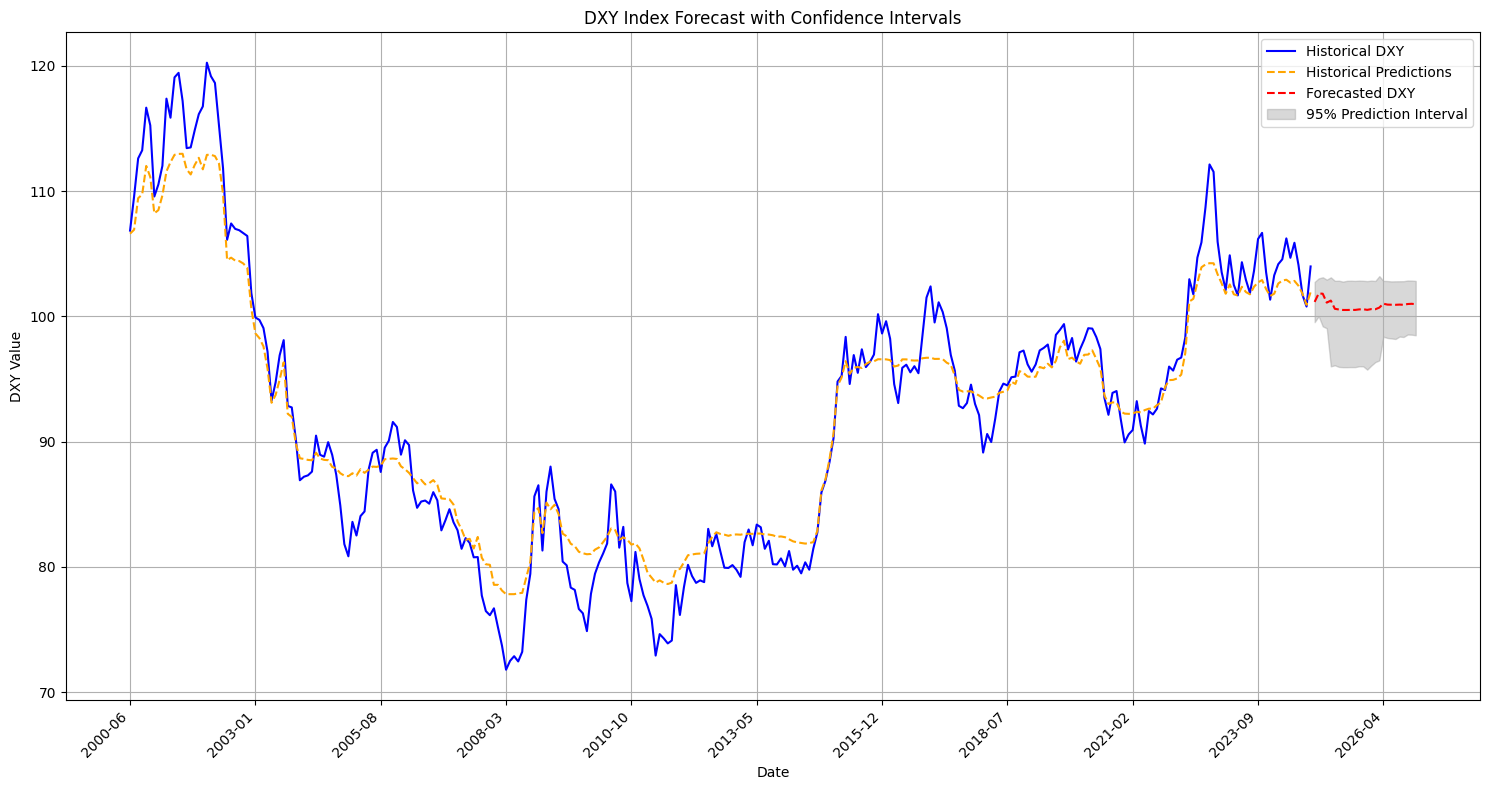

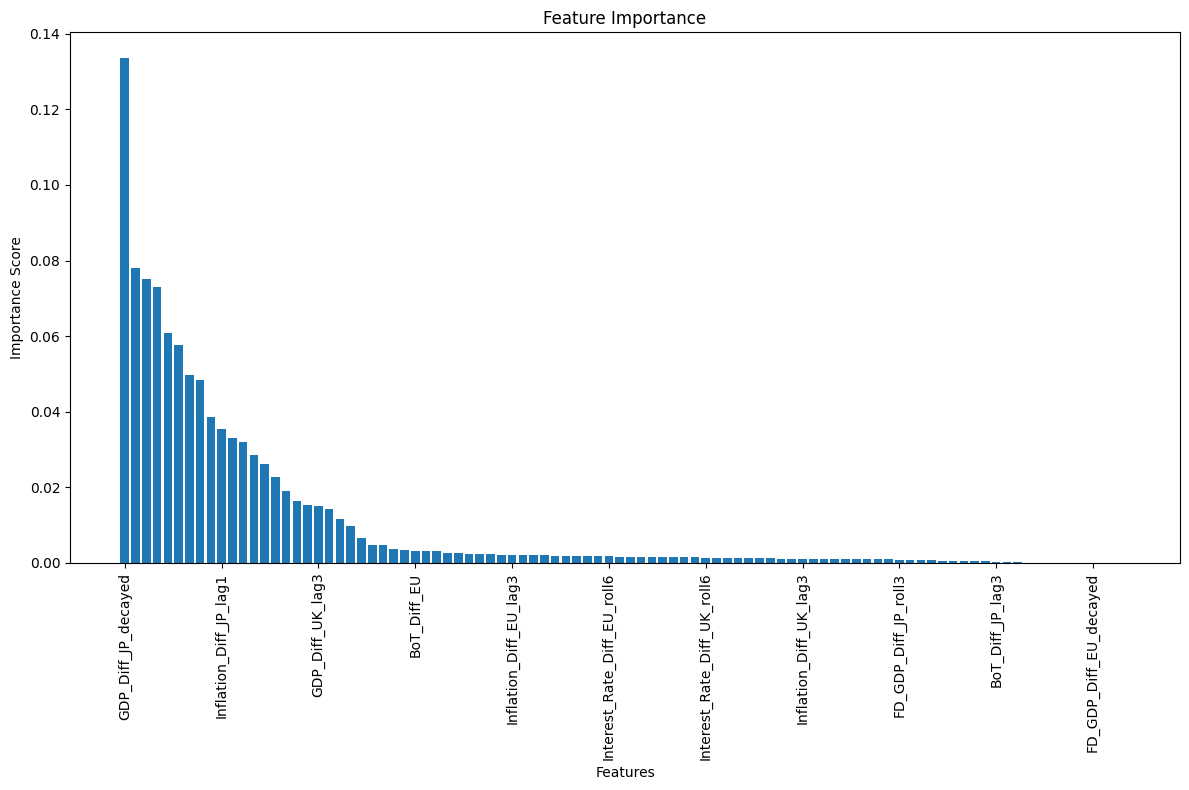

In [11]:
def create_projection_table(dxy_forecast_df, dxy_data, currency_data, base_currency='USD'):
    """Create a detailed projection table for currency pairs at specific intervals"""
    try:
        # Calculate initial projections
        projected_pairs = project_currency_pairs(dxy_forecast_df, dxy_data, currency_data, base_currency)

        # Define the intervals we want to show (in months)
        intervals = [3, 6, 12, 18, 24]

        # Get current rates
        latest_eur = currency_data['EUR/USD'].dropna().iloc[-1]
        latest_gbp = currency_data['GBP/USD'].dropna().iloc[-1]
        latest_jpy = currency_data['USD/JPY'].dropna().iloc[-1]

        # Create dictionary for storing data
        table_data = {
            'EUR/USD': {'Current': latest_eur},
            'GBP/USD': {'Current': latest_gbp},
            'USD/JPY': {'Current': latest_jpy}
        }

        # Calculate volatility metrics
        for pair in ['EUR/USD', 'GBP/USD', 'USD/JPY']:
            returns = currency_data[pair].pct_change().dropna()
            volatility = returns.std() * np.sqrt(252)  # Annualized volatility
            table_data[pair]['Implied Volatility (%)'] = volatility * 100

        # Add projections for each interval
        for interval in intervals:
            interval_date = projected_pairs.index[min(interval-1, len(projected_pairs)-1)]
            projection_key = f"{interval}M Projection"
            pct_change_key = f"{interval}M % Change"

            for pair in ['EUR/USD', 'GBP/USD', 'USD/JPY']:
                # Add projection
                projected_value = projected_pairs.loc[interval_date, pair]
                table_data[pair][projection_key] = projected_value

                # Calculate and add percentage change
                pct_change = ((projected_value - table_data[pair]['Current']) /
                              table_data[pair]['Current'] * 100)
                table_data[pair][pct_change_key] = pct_change

        # Convert to DataFrame with specific row order
        row_order = ['Current'] + \
                    [f"{i}M Projection" for i in intervals] + \
                    ['Implied Volatility (%)'] + \
                    [f"{i}M % Change" for i in intervals]

        projection_table = pd.DataFrame(table_data)
        projection_table = projection_table.reindex(row_order)

        # Format the values
        for idx in projection_table.index:
            if 'Projection' in idx or idx == 'Current':
                projection_table.loc[idx] = projection_table.loc[idx].round(4)
            elif 'Change' in idx or 'Volatility' in idx:
                projection_table.loc[idx] = projection_table.loc[idx].round(2)

        return projection_table

    except Exception as e:
        print(f"Error in create_projection_table: {str(e)}")
        traceback.print_exc()
        return pd.DataFrame()

def format_projection_output(projection_table):
    """Format the projection table for nice display"""
    formatted_table = projection_table.copy()

    # Add spacing for better readability
    formatted_table.index = ['\n' + idx if 'Projection' in idx else idx for idx in formatted_table.index]

    # Format percentage values
    for idx in formatted_table.index:
        if 'Change' in idx or 'Volatility' in idx:
            formatted_table.loc[idx] = formatted_table.loc[idx].apply(lambda x: f"{x:,.2f}%")
        else:
            formatted_table.loc[idx] = formatted_table.loc[idx]

    return formatted_table

def main():
    """Main function to run the analysis"""
    try:
        csv_file_path = '/Users/pawan/Desktop/Quantwater Tech Investments/Research & Development/Research/Markets/DXY/Data - Inflation & Interest Rate - Granular9 - B.csv'
        
        print("Loading and preparing data...")
        data = load_and_prepare_data(csv_file_path)
        data = data[data.index >= pd.Period('2000-01')]
        
        # Update the end date for historical data
        historical_end_date = '2024-09-30'
        forecast_start_date = '2024-10-01'

        
        if not validate_data(data):
            raise ValueError("Data validation failed")
        if data is None:
            raise ValueError("Failed to load data from CSV file")
        
        print("\nData shape:", data.shape)
        print("\nData columns:", data.columns.tolist())
        print("\nFirst few rows of data:")
        print(data.head())
        


        # Fetch DXY data
        print("\nFetching DXY data...")
        dxy_data = fetch_dxy_data()
        if dxy_data is None:
            raise ValueError("Failed to fetch DXY data")

        # Fetch currency pair data
        print("\nFetching currency pair data...")
        currency_pairs = {}
        for pair, symbol in [('EUR/USD', 'EURUSD=X'), ('GBP/USD', 'GBPUSD=X'), ('USD/JPY', 'JPY=X')]:
            data_pair = fetch_currency_data(symbol)
            if data_pair is not None:
                currency_pairs[pair] = data_pair
                print(f"Successfully fetched {pair} data")
            else:
                print(f"Warning: Failed to fetch {pair} data")

        if not currency_pairs:
            raise ValueError("Failed to fetch any currency pair data")

        print("\nPreparing analysis data...")
        differentials = prepare_analysis_data(data)
        if differentials is None:
            raise ValueError("Failed to prepare differentials")

        merged_data = merge_with_dxy(differentials, dxy_data)
        if merged_data is None:
            raise ValueError("Failed to merge data")

        # Initialize and run analysis
        print("\nRunning analysis...")
        analyzer = ShockAwareAnalysis(merged_data)
        results = analyzer.run_analysis()

        if results is None:
            raise ValueError("Analysis failed to complete")

        # Generate projection table
        projection_table = create_projection_table(results['forecast'], dxy_data, currency_pairs)
        formatted_table = format_projection_output(projection_table)

        print("\nCurrency Pair Projections:")
        print(formatted_table)

        # Optionally, save the forecast plot
        forecast_plot = results['plots']['forecast']
        if forecast_plot is not None:
            forecast_plot.savefig('dxy_forecast.png')
            print("\nForecast plot saved as 'dxy_forecast.png'")

        # Optionally, save the feature importance plot
        importance_plot = results['plots']['importance']
        if importance_plot is not None:
            importance_plot.savefig('feature_importance.png')
            print("\nFeature importance plot saved as 'feature_importance.png'")

        # Save projection table to CSV
        projection_table.to_csv('currency_projections.csv')
        print("\nProjection table saved as 'currency_projections.csv'")

        # Proceed with the rest of your analysis...
        # (Rest of the code remains the same)
        
    except Exception as e:
        print(f"Error in main function: {e}")
        print("Stack trace:")
        traceback.print_exc()

if __name__ == "__main__":
    main()